# Facial Expression Recognition

## Data sources

Challenges in Representation Learning: Facial Expression Recognition Challenge

- https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview

## Fer2013Plus

Better labels for the FER emotion recognition dataset by Microsoft

- Origin (only have new data fer2013new): https://github.com/microsoft/FERPlus
- Processed (fer2013 + fer2013new) https://www.kaggle.com/datasets/subhaditya/fer2013plus


## Keras facenet h5

Pre trained Model (not used! maybe later?)
Link: https://www.kaggle.com/datasets/rmamun/kerasfaceneth5?resource=download


In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

import tensorflow as tf
from tensorflow import keras
from keras import layers, activations, losses, metrics, optimizers, callbacks, regularizers
from keras.utils import image_dataset_from_directory
from keras.models import load_model, model_from_json, Sequential


In [400]:
tf.__version__

'2.11.0'

In [401]:
img_dir = "../data/fer2013plus/fer2013plus/"
train_img_count = sum(len(files) for _, _, files in os.walk(f'{img_dir}train'))
test_img_count = sum(len(files) for _, _, files in os.walk(f'{img_dir}test'))
print("training image count: ", train_img_count)
print("test image count: ", test_img_count)


training image count:  28387
test image count:  7100


In [402]:
batch_size = 32
img_dimention = 48
img_channels = 3
img_dimention_tg = img_dimention * 4


In [403]:
def getDs(label="train"):
    return image_dataset_from_directory(
        f"{img_dir}{label}",
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(img_dimention, img_dimention),
        shuffle=True,
        seed=16891
    )


In [404]:
train_ds = getDs("train")
test_ds = getDs("test")


Found 28386 files belonging to 8 classes.
Found 7099 files belonging to 8 classes.


In [405]:
print(train_ds.class_names)


['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [406]:
print("batchs: ", len(train_ds), f"x {batch_size} =", len(train_ds)*batch_size)
for image_batch, labels_batch in train_ds:
    print("images: ", image_batch.shape)
    print("labels", labels_batch.shape)
    for img in image_batch:
        print("channels", img[2][:2])
        break
    break


batchs:  888 x 32 = 28416
images:  (32, 48, 48, 3)
labels (32,)
channels tf.Tensor(
[[162. 162. 162.]
 [131. 131. 131.]], shape=(2, 3), dtype=float32)


In [407]:
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    #print(np.where(label[0] == 1)[0].item())


Image shape:  (32, 48, 48, 3)
Label:  [5 4 7 3 7 5 5 4 4 0 7 4 4 0 5 7 4 5 5 7 4 5 5 4 4 5 7 5 6 7 5 5]


In [408]:
def img_preview(ds=train_ds, img_nr=5):
    plt.figure(figsize=(12, 12))
    for images, labels in ds.take(1):
        for i in range(img_nr * img_nr):
            ax = plt.subplot(img_nr, img_nr, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(ds.class_names[labels[i]])
            plt.axis("off")


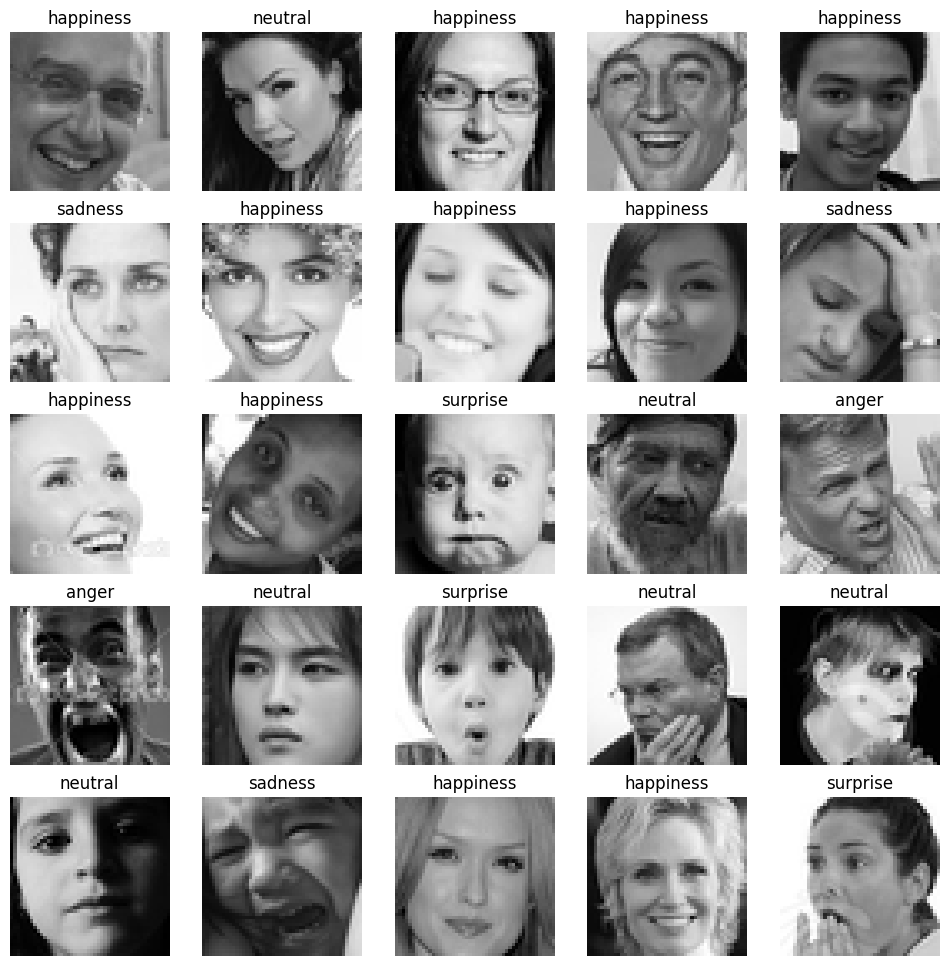

In [409]:
img_preview()


In [410]:
num_classes = len(train_ds.class_names)
num_classes


8

In [411]:
# RandomFlip, RandomRotation ... not work on version tensorflow 2.9
# working on tf 2.11 but execution not working, waiting for bug fix to use this

# data_augmentation = Sequential(
#     [
#         layers.Input(shape=(img_dimention, img_dimention, img_channels)),
#         layers.RandomFlip(),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#     ], name="data_augmentation"
# )


In [412]:
# def img_preview_data_augmentation():
#     plt.figure(figsize=(10, 10))
#     for images, _ in train_ds.take(1):
#         for i in range(9):
#             augmented_images = data_augmentation(images) # todo: works on tensorflow 2.11 but not 2.9
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_images[0].numpy().astype("uint8"))
#             plt.axis("off")
# img_preview_data_augmentation()

In [413]:
model = Sequential(layers=[
    layers.Input(shape=(img_dimention, img_dimention, img_channels)),
    # data_augmentation,
    # layers.Rescaling(1./255, name="normalization_layer"),
    layers.Conv2D(64, 3, activation=activations.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation=activations.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation=activations.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, activation=activations.relu),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation=activations.relu,
                 kernel_regularizer=regularizers.L2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(128, activation=activations.relu),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation=activations.softmax)
], name="fer-plus-emotion-recognition-model")


In [414]:
model.summary()


Model: "fer-plus-emotion-recognition-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_84 (MaxPoolin  (N

In [415]:
# Deprecated method is used: because of MAC M1 Tensorflow bugs!

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f"{img_dir}train",
    target_size=(img_dimention, img_dimention),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    f"{img_dir}test",
    target_size=(img_dimention, img_dimention),
    batch_size=batch_size,
    class_mode='categorical')


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [416]:
print(len(train_generator))
print(len(test_generator))

888
222


In [417]:
# def configure_for_performance(ds):
#     ds = ds.cache()
#     ds = ds.shuffle(buffer_size=1000)
#     ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
#     return ds

# train_ds = configure_for_performance(train_generator)
# test_ds = configure_for_performance(test_generator)


In [418]:
epochs = 200
stopAccuracyRate = 0.99

In [419]:
model.compile(
    steps_per_execution=20,
    optimizer=optimizers.Nadam(),
    loss=losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [420]:
class StopTrainingCallback(callbacks.Callback):
    def on_epoch_end(self, _, logs=None):
        if logs.get('accuracy') is not None and logs.get('accuracy') > stopAccuracyRate:
            print(
                f"\nReached {stopAccuracyRate*100}% accuracy so cancelling training!")
            self.model.stop_training = True


In [421]:
checkpoint_filepath = "../outputs/fer2013plus_checkpoint"

checkPointCallback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)


In [422]:
def show_gen_info():
    print(train_generator.image_shape)
    print(test_generator.image_shape)
    for images, labels in train_generator:
        print(images.shape)
        print(labels.shape)
        break

show_gen_info()

(48, 48, 3)
(48, 48, 3)
(32, 48, 48, 3)
(32, 8)


In [423]:
# model.load_weights(checkpoint_filepath)

In [424]:
h = model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    # steps_per_epoch= 160, # (train_img_count // batch_size) // epochs,
    validation_data=test_generator,
    validation_batch_size=batch_size,
    callbacks=[checkPointCallback]
)


Epoch 1/200


2023-03-02 10:44:05.218066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


888/888 [==============================] - ETA: 0s - loss: 1.7748 - accuracy: 0.3568

2023-03-02 10:44:34.985260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


888/888 [==============================] - 34s 38ms/step - loss: 1.7748 - accuracy: 0.3568 - val_loss: 1.6048 - val_accuracy: 0.3658
Epoch 2/200
888/888 [==============================] - 29s 33ms/step - loss: 1.5676 - accuracy: 0.3752 - val_loss: 1.4838 - val_accuracy: 0.4175
Epoch 3/200
888/888 [==============================] - 30s 33ms/step - loss: 1.4711 - accuracy: 0.4172 - val_loss: 1.4171 - val_accuracy: 0.4719
Epoch 4/200
888/888 [==============================] - 30s 34ms/step - loss: 1.3713 - accuracy: 0.4935 - val_loss: 1.1891 - val_accuracy: 0.5959
Epoch 5/200
888/888 [==============================] - 31s 35ms/step - loss: 1.2279 - accuracy: 0.5670 - val_loss: 1.0888 - val_accuracy: 0.6259
Epoch 6/200
888/888 [==============================] - 31s 35ms/step - loss: 1.1662 - accuracy: 0.5910 - val_loss: 1.0320 - val_accuracy: 0.6487
Epoch 7/200
888/888 [==============================] - 30s 34ms/step - loss: 1.1235 - accuracy: 0.6097 - val_loss: 1.0196 - val_accuracy: 0.65

In [425]:
def plot_history(h, title):
    x_axis = [i for i in range(len(list(h.history.values())[0]))]

    for name in h.history:
        plt.plot(x_axis, h.history[name], label=name)

    plt.legend(title=title)
    plt.show()


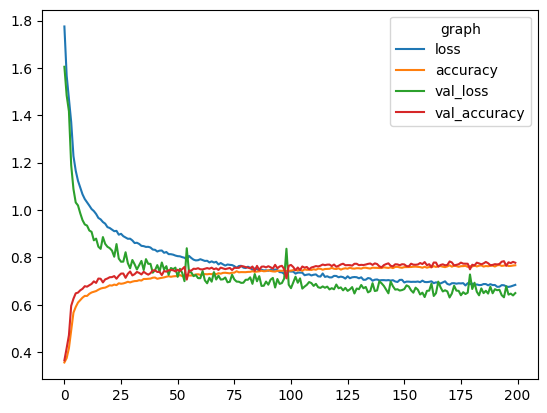

In [426]:
plot_history(h, "graph")


In [427]:
output_dir = "../outputs/fer2013plus/"
model.save(output_dir)


INFO:tensorflow:Assets written to: ../outputs/fer2013plus/assets


INFO:tensorflow:Assets written to: ../outputs/fer2013plus/assets
